In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def json_to_2_lists(json_file):
  with open(json_file) as f:
    data = json.load(f)
  neg_scores = []
  pos_scores = []
  for document in data:
    neg_scores.append(document["average_negative_score"]["value"])
    pos_scores.append(document["average_positive_score"]["value"])
  return neg_scores, pos_scores

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PEDRO_SANCHEZ_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/0101_0630_splitted.json'
OBRADOR_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/262.json'
FIGUERES_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/555.json'
CHAVES_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/609.json'
MENORCA_PATH = '/content/drive/My Drive/Naveler/03.TECH/data_discovery/datasets/1803.json'

sanchez_negative_scores, sanchez_positive_scores = json_to_2_lists(PEDRO_SANCHEZ_PATH)
obrador_negative_scores, obrador_positive_scores = json_to_2_lists(OBRADOR_PATH)
figueres_negative_scores, figueres_positive_scores = json_to_2_lists(FIGUERES_PATH)
chaves_negative_scores, chaves_positive_scores = json_to_2_lists(CHAVES_PATH)
menorca_negative_scores, menorca_positive_scores = json_to_2_lists(MENORCA_PATH)

Mounted at /content/drive


In [ ]:
sanchez_scores = np.array(sanchez_positive_scores) - np.array(sanchez_negative_scores)
print(f'Pedro Sánchez: {len(sanchez_scores)}')

obrador_scores = np.array(obrador_positive_scores) - np.array(obrador_negative_scores)
print(f'Obrador: {len(obrador_scores)}')

figueres_scores = np.array(figueres_positive_scores) - np.array(figueres_negative_scores)
print(f'Figueres: {len(figueres_scores)}')

chaves_scores = np.array(chaves_positive_scores) - np.array(chaves_negative_scores)
print(f'Chaves: {len(chaves_scores)}')

menorca_scores = np.array(menorca_positive_scores) - np.array(menorca_negative_scores)
print(f'Menorca: {len(menorca_scores)}')

Pedro Sánchez: 682
Obrador: 1373
Figueres: 1214
Chaves: 1192
Menorca: 284


In [ ]:
def sigmoid (x, A, h, slope, C):
    return A/(1 + np.exp(-x*slope + h)) + C

In [ ]:
# Sigmoid parameters
A = 100 # we want values from 0 to 100
h = 0 # bring down the center of the curve (if score=0 -> NSI<50 if h>0)
slope = 20 # the higher the slope, the higher the variance around score 0
C = 0 # we don't want a vertical offset

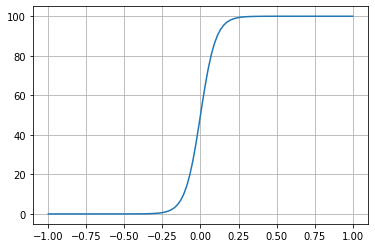

In [ ]:
x_plot = np.linspace(-1, 1, 100)
f = np.vectorize(sigmoid)
y_plot = f(x_plot, A, h, slope, C)
plt.plot(x_plot, y_plot)
plt.grid()
plt.show()
#print(sigmoid(-1, A, h, slope, C), sigmoid(0, A, h, slope, C), sigmoid(1, A, h, slope, C))

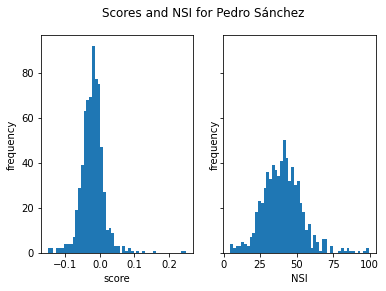

Median score: -0.02
97% confidence interval for the scores: [-0.1, 0.07]
Median NSI: 40.14
97% confidence interval for the NSI: [11.57, 80.18]


In [ ]:
sanchez_NSI = f(sanchez_scores, A, h, slope, C)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(sanchez_scores, bins=50)
ax2.hist(sanchez_NSI, bins=50)
fig.suptitle("Scores and NSI for Pedro Sánchez")
ax1.set_xlabel("score")
ax2.set_xlabel("NSI")
ax1.set_ylabel("frequency")
ax2.set_ylabel("frequency")
plt.show()
print(f'Median score: {round(np.median(sanchez_scores), 2)}')
print(f'97% confidence interval for the scores: [{round(np.percentile(sanchez_scores, 1.5), 2)}, {round(np.percentile(sanchez_scores, 98.5), 2)}]')
print(f'Median NSI: {round(np.median(sanchez_NSI), 2)}')
print(f'97% confidence interval for the NSI: [{round(np.percentile(sanchez_NSI, 1.5), 2)}, {round(np.percentile(sanchez_NSI, 98.5), 2)}]')

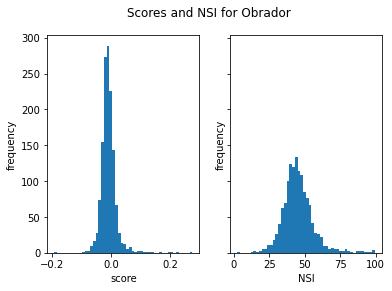

Median score: -0.01
97% confidence interval for the scores: [-0.06, 0.07]
Median NSI: 44.17
97% confidence interval for the NSI: [24.08, 78.8]


In [ ]:
obrador_NSI = f(obrador_scores, A, h, slope, C)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(obrador_scores, bins=50)
ax2.hist(obrador_NSI, bins=50)
fig.suptitle("Scores and NSI for Obrador")
ax1.set_xlabel("score")
ax2.set_xlabel("NSI")
ax1.set_ylabel("frequency")
ax2.set_ylabel("frequency")
plt.show()
print(f'Median score: {round(np.median(obrador_scores), 2)}')
print(f'97% confidence interval for the scores: [{round(np.percentile(obrador_scores, 1.5), 2)}, {round(np.percentile(obrador_scores, 98.5), 2)}]')
print(f'Median NSI: {round(np.median(obrador_NSI), 2)}')
print(f'97% confidence interval for the NSI: [{round(np.percentile(obrador_NSI, 1.5), 2)}, {round(np.percentile(obrador_NSI, 98.5), 2)}]')

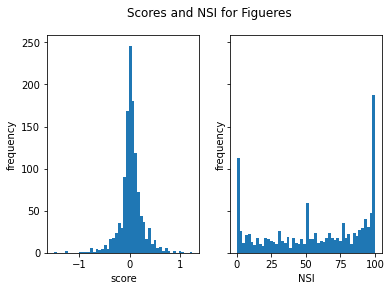

Median score: 0.02
97% confidence interval for the scores: [-0.61, 0.62]
Median NSI: 62.21
97% confidence interval for the NSI: [0.0, 100.0]


In [ ]:
figueres_NSI = f(figueres_scores, A, h, slope, C)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(figueres_scores, bins=50)
ax2.hist(figueres_NSI, bins=50)
fig.suptitle("Scores and NSI for Figueres")
ax1.set_xlabel("score")
ax2.set_xlabel("NSI")
ax1.set_ylabel("frequency")
ax2.set_ylabel("frequency")
plt.show()
print(f'Median score: {round(np.median(figueres_scores), 2)}')
print(f'97% confidence interval for the scores: [{round(np.percentile(figueres_scores, 1.5), 2)}, {round(np.percentile(figueres_scores, 98.5), 2)}]')
print(f'Median NSI: {round(np.median(figueres_NSI), 2)}')
print(f'97% confidence interval for the NSI: [{round(np.percentile(figueres_NSI, 1.5), 2)}, {round(np.percentile(figueres_NSI, 98.5), 2)}]')

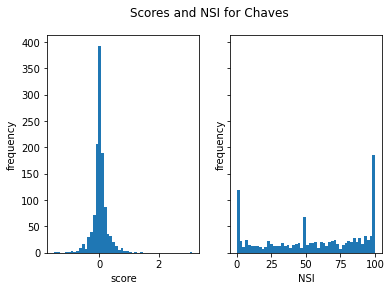

Median score: 0.02
97% confidence interval for the scores: [-0.6, 0.75]
Median NSI: 58.99
97% confidence interval for the NSI: [0.0, 100.0]


In [ ]:
chaves_NSI = f(chaves_scores, A, h, slope, C)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(chaves_scores, bins=50)
ax2.hist(chaves_NSI, bins=50)
fig.suptitle("Scores and NSI for Chaves")
ax1.set_xlabel("score")
ax2.set_xlabel("NSI")
ax1.set_ylabel("frequency")
ax2.set_ylabel("frequency")
plt.show()
print(f'Median score: {round(np.median(chaves_scores), 2)}')
print(f'97% confidence interval for the scores: [{round(np.percentile(chaves_scores, 1.5), 2)}, {round(np.percentile(chaves_scores, 98.5), 2)}]')
print(f'Median NSI: {round(np.median(chaves_NSI), 2)}')
print(f'97% confidence interval for the NSI: [{round(np.percentile(chaves_NSI, 1.5), 2)}, {round(np.percentile(chaves_NSI, 98.5), 2)}]')

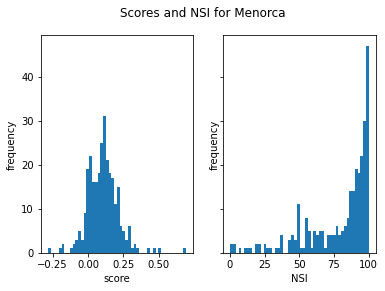

Median score: 0.11
97% confidence interval for the scores: [-0.12, 0.35]
Median NSI: 89.36
97% confidence interval for the NSI: [8.41, 99.91]


In [ ]:
menorca_NSI = f(menorca_scores, A, h, slope, C)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(menorca_scores, bins=50)
ax2.hist(menorca_NSI, bins=50)
fig.suptitle("Scores and NSI for Menorca")
ax1.set_xlabel("score")
ax2.set_xlabel("NSI")
ax1.set_ylabel("frequency")
ax2.set_ylabel("frequency")
plt.show()
print(f'Median score: {round(np.median(menorca_scores), 2)}')
print(f'97% confidence interval for the scores: [{round(np.percentile(menorca_scores, 1.5), 2)}, {round(np.percentile(menorca_scores, 98.5), 2)}]')
print(f'Median NSI: {round(np.median(menorca_NSI), 2)}')
print(f'97% confidence interval for the NSI: [{round(np.percentile(menorca_NSI, 1.5), 2)}, {round(np.percentile(menorca_NSI, 98.5), 2)}]')